## Sistem preporuka polovnih automobila zasnovan na Two-Tower arhitekturi

Cilj ovog projekta je izgradnja sistema za preporuku polovnih automobila koji uči zajednički embedding prostor za korisnike i vozila koristeći Two-Tower neuronsku arhitekturu. Model povezuje sintetičke korisničke preferencije i karakteristike automobila kako bi identifikovao najrelevantnije preporuke na osnovu njihove sličnosti.


In [43]:
import re
import numpy as np
import pandas as pd

np.random.seed(42)

def extract_float(series: pd.Series) -> pd.Series:
    """
    Izvlaci prvi decimalni broj iz stringa (npr. '23.4 kmpl', '1248 CC')
    Ako nema broja, vraca NaN
    """
    s = series.astype(str)
    return pd.to_numeric(s.str.extract(r"(\d+\.?\d*)")[0], errors="coerce")

def parse_torque_to_nm(torque_series: pd.Series) -> pd.Series:
    """
     Izvlaci vrednost obrtnog momenta, ako je u kgm/kg-m, konvertuje u Nm
    """
    raw = torque_series.astype(str)
    val = pd.to_numeric(raw.str.extract(r"(\d+\.?\d*)")[0], errors="coerce")
    is_kgm = raw.str.contains(r"kgm|kg-m", case=False, na=False)
    val_nm = val.copy()
    val_nm.loc[is_kgm] = val_nm.loc[is_kgm] * 9.80665
    return val_nm

def extract_brand(name_series: pd.Series) -> pd.Series:
    """
    Brend je prva rec u nazivu automobila
    """
    s = name_series.astype(str).str.strip()
    return s.str.split().str[0].fillna("Unknown")


df = pd.read_csv("./car-details-v4.csv")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Hyundai Grand i10 CRDi Asta Option,2013,270000,118000,Diesel,Individual,Manual,First Owner,24.0 kmpl,1120 CC,70 bhp,160Nm@ 1500-2750rpm,5.0
1,Hyundai Verna 1.6 SX,2013,420000,69000,Diesel,Individual,Manual,Third Owner,22.32 kmpl,1582 CC,126.32 bhp,259.8Nm@ 1900-2750rpm,5.0
2,Maruti Swift Dzire LXI,2015,434999,25000,Petrol,Individual,Manual,Second Owner,20.85 kmpl,1197 CC,83.14 bhp,115Nm@ 4000rpm,5.0
3,Hyundai Xcent 1.2 Kappa AT S Option,2015,400000,100000,Petrol,Individual,Automatic,First Owner,16.9 kmpl,1197 CC,81.86 bhp,113.75Nm@ 4000rpm,5.0
4,Maruti Swift Dzire VDI,2015,470000,110000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0


In [46]:
df = df[
    [
        "name",
        "year",
        "selling_price",
        "km_driven",
        "fuel",
        "seller_type",
        "transmission",
        "owner",
        "mileage",
        "engine",
        "max_power",
        "torque",
        "seats",
    ]
].copy()

In [47]:
df["mileage"] = extract_float(df["mileage"])
df["engine"] = extract_float(df["engine"])
df["max_power"] = extract_float(df["max_power"])
df["torque_nm"] = parse_torque_to_nm(df["torque"])
df["seats"] = pd.to_numeric(df["seats"], errors="coerce")

name = df["name"].astype(str)

df["body_coupe"] = name.str.contains(
    r"Coupe|Sports|Roadster|Convertible|Cabrio|Cabriolet|TT|Z4|S2000|Mustang|GT\b",
    case=False,
    na=False,
).astype(int)

df["body_sedan"] = name.str.contains(
    r"\bSedan\b|Dzire|City|Verna|Civic|Corolla|Passat|Octavia|Jetta|C-Class|S-Class",
    case=False,
    na=False,
).astype(int)

df["body_suv"] = name.str.contains(
    r"Scorpio|Bolero|Fortuner|Safari|Innova|Jeep|XUV|Endeavour|Creta|Harrier|Hector|Duster",
    case=False,
    na=False,
).astype(int)

df["brand"] = extract_brand(df["name"])

premium_brands = {
    "Mercedes",
    "BMW",
    "Audi",
    "Lexus",
    "Jaguar",
    "Volvo",
    "Porsche",
    "Land",
    "Range",
}

df["is_premium_brand"] = df["brand"].isin(premium_brands).astype(int)
df.loc[name.str.contains(r"Land Rover", case=False, na=False), "is_premium_brand"] = 1
df.loc[name.str.contains(r"Range Rover", case=False, na=False), "is_premium_brand"] = 1

cat_cols = ["fuel", "seller_type", "transmission", "owner"]
for c in cat_cols:
    df[c] = (
        df[c]
        .astype(str)
        .replace({"nan": np.nan, "None": np.nan})
        .fillna("Unknown")
        .str.strip()
    )

for c in ["year", "selling_price", "km_driven"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["name", "year", "selling_price", "km_driven"]).copy()

num_cols = ["mileage", "engine", "max_power", "torque_nm", "seats"]

for c in num_cols:
    med = df[c].median()
    df[c] = df[c].fillna(med)

df = df[df["year"].between(1980, 2030)]
df = df[df["selling_price"] > 0]
df = df[df["km_driven"] >= 0]
df = df[df["seats"].between(2, 10)]

df.reset_index(drop=True, inplace=True)
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,torque_nm,body_coupe,body_sedan,body_suv,brand,is_premium_brand
0,Hyundai Grand i10 CRDi Asta Option,2013,270000,118000,Diesel,Individual,Manual,First Owner,24.00,1120.0,70.00,160Nm@ 1500-2750rpm,5.0,160.00,0,0,0,Hyundai,0
1,Hyundai Verna 1.6 SX,2013,420000,69000,Diesel,Individual,Manual,Third Owner,22.32,1582.0,126.32,259.8Nm@ 1900-2750rpm,5.0,259.80,0,1,0,Hyundai,0
2,Maruti Swift Dzire LXI,2015,434999,25000,Petrol,Individual,Manual,Second Owner,20.85,1197.0,83.14,115Nm@ 4000rpm,5.0,115.00,0,1,0,Maruti,0
3,Hyundai Xcent 1.2 Kappa AT S Option,2015,400000,100000,Petrol,Individual,Automatic,First Owner,16.90,1197.0,81.86,113.75Nm@ 4000rpm,5.0,113.75,0,0,0,Hyundai,0
4,Maruti Swift Dzire VDI,2015,470000,110000,Diesel,Individual,Manual,First Owner,26.59,1248.0,74.00,190Nm@ 2000rpm,5.0,190.00,0,1,0,Maruti,0


In [48]:
df.describe()

,year,selling_price,km_driven,mileage,engine,max_power,seats,torque_nm,body_coupe,body_sedan,body_suv,is_premium_brand
count,1636.000000,1.636000e+03,1.636000e+03,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000
mean,2014.342298,1.875745e+06,6.537767e+04,18.091589,1666.175428,135.750807,5.221271,228.578942,0.035452,0.092910,0.124083,0.072738
std,4.453794,5.702215e+06,5.843320e+04,5.196142,945.871124,141.258414,1.085320,184.421389,0.184977,0.290394,0.329777,0.259786
min,1995.000000,3.000000e+04,1.000000e+00,0.000000,0.000000,0.000000,2.000000,48.000000,0.000000,0.000000,0.000000,0.000000
25%,2012.000000,2.600000e+05,2.900000e+04,15.370000,1197.000000,70.000000,5.000000,113.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,4.970000e+05,5.878850e+04,18.600000,1396.000000,88.200000,5.000000,190.000000,0.000000,0.000000,0.000000,0.000000
75%,2018.000000,8.204992e+05,9.000000e+04,21.660000,1991.000000,121.300000,5.000000,259.800000,0.000000,0.000000,0.000000,0.000000
max,2024.000000,1.250000e+08,1.500000e+06,32.520000,7011.000000,1035.000000,10.000000,1430.000000,1.000000,1.000000,1.000000,1.000000


### EDA (Exploratory Data Analysis)

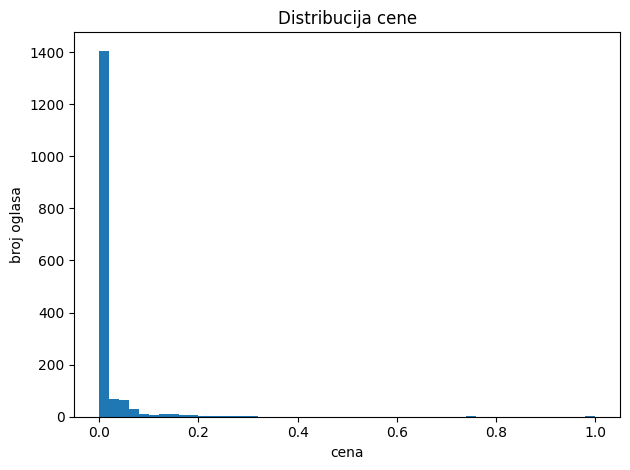

In [69]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["selling_price"].dropna(), bins=50)
plt.title("Distribucija cene")
plt.xlabel("cena")
plt.ylabel("broj oglasa")
plt.tight_layout()
plt.show()

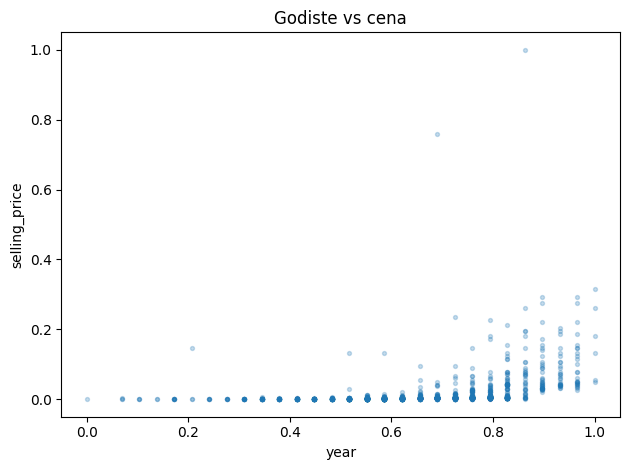

In [71]:
plt.figure()
plt.scatter(df["year"], df["selling_price"], s=8, alpha=0.25)
plt.title("Godiste vs cena")
plt.xlabel("year")
plt.ylabel("selling_price")
plt.tight_layout()
plt.show()

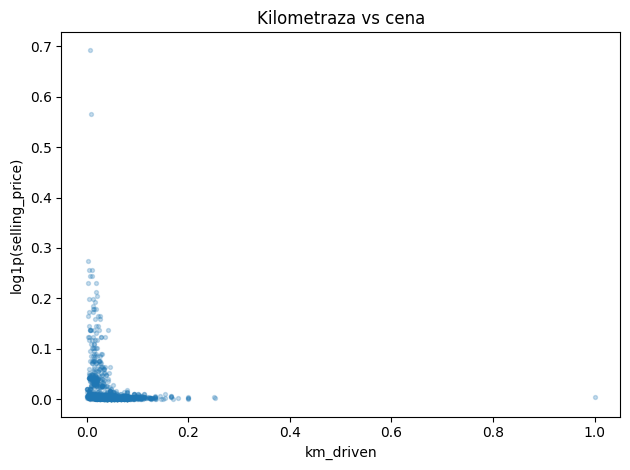

In [72]:
plt.figure()
plt.scatter(df["km_driven"], np.log1p(df["selling_price"]), s=8, alpha=0.25)
plt.title("Kilometraza vs cena")
plt.xlabel("km_driven")
plt.ylabel("log1p(selling_price)")
plt.tight_layout()
plt.show()

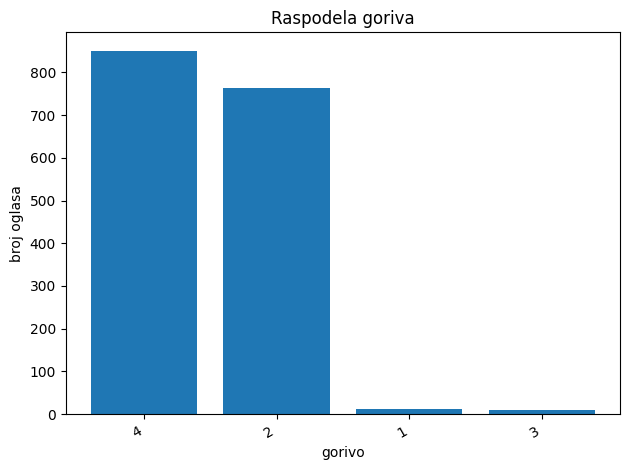

In [76]:
fuel_counts = df["fuel"].value_counts(dropna=False)
plt.figure()
plt.bar(fuel_counts.index.astype(str), fuel_counts.values)
plt.title("Raspodela goriva")
plt.xlabel("gorivo")
plt.ylabel("broj oglasa")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

1. Metan (CNG)
2. Dizel
3. Plin (LPG)
4. Benzin

/var/folders/1z/y0431qm13ys1l9h5w9tslfgw0000gn/T/ipykernel_58114/3924670442.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([non_premium.dropna(), premium.dropna()], labels=["non-premium", "premium"])


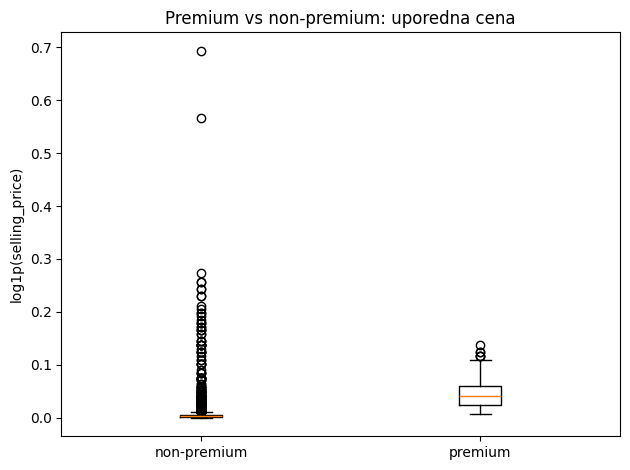

In [78]:
premium = np.log1p(df.loc[df["is_premium_brand"] == 1, "selling_price"])
non_premium = np.log1p(df.loc[df["is_premium_brand"] == 0, "selling_price"])

plt.figure()
plt.boxplot([non_premium.dropna(), premium.dropna()], labels=["non-premium", "premium"])
plt.title("Premium vs non-premium: uporedna cena")
plt.ylabel("log1p(selling_price)")
plt.tight_layout()
plt.show()

### Preprocesiranje/Enkodiranje

In [80]:
from sklearn.preprocessing import MinMaxScaler

NUM_COLS = [
    "year",
    "selling_price",
    "km_driven",
    "mileage",
    "engine",
    "max_power",
    "torque_nm",
    "seats",
]

CAT_COLS = ["fuel", "seller_type", "transmission", "owner"]
BIN_COLS = ["body_suv", "body_sedan", "body_coupe", "is_premium_brand"]

for c in CAT_COLS:
    df[c] = df[c].fillna("Unknown").astype(str).str.strip()

scaler = MinMaxScaler()
df[NUM_COLS] = scaler.fit_transform(df[NUM_COLS])

cat_maps = {}
cat_sizes = {}

for c in CAT_COLS:
    cats = pd.Index(sorted(df[c].unique()))
    if "Unknown" not in cats:
        cats = pd.Index(["Unknown"]).append(cats)
    cat_maps[c] = {k: i for i, k in enumerate(cats)}
    cat_sizes[c] = len(cats)
    df[c] = df[c].map(cat_maps[c]).fillna(cat_maps[c]["Unknown"]).astype(int)

num_fuel = cat_sizes["fuel"]
num_seller = cat_sizes["seller_type"]
num_trans = cat_sizes["transmission"]
num_owner = cat_sizes["owner"]

def get_code(col: str, name: str) -> int:
    return cat_maps[col].get(name, cat_maps[col]["Unknown"])

petrol_code = get_code("fuel", "Petrol")
diesel_code = get_code("fuel", "Diesel")

manual_code = get_code("transmission", "Manual")
auto_code = get_code("transmission", "Automatic")

first_owner_code = get_code("owner", "First Owner")

df_items = df[NUM_COLS + CAT_COLS + BIN_COLS].copy()
df_items.head()

,year,selling_price,km_driven,mileage,engine,max_power,torque_nm,seats,fuel,seller_type,transmission,owner,body_suv,body_sedan,body_coupe,is_premium_brand
0,0.620690,0.001920,0.078666,0.738007,0.159749,0.067633,0.081042,0.375,2,2,2,1,0,0,0,0
1,0.620690,0.003121,0.045999,0.686347,0.225645,0.122048,0.153256,0.375,2,2,2,4,0,1,0,0
2,0.689655,0.003241,0.016666,0.641144,0.170732,0.080329,0.048480,0.375,4,2,2,3,0,1,0,0
3,0.689655,0.002961,0.066666,0.519680,0.170732,0.079092,0.047576,0.375,4,2,1,1,0,0,0,0
4,0.689655,0.003521,0.073333,0.817651,0.178006,0.071498,0.102750,0.375,2,2,2,1,0,1,0,0


In [81]:
df_items.isna().sum()

year                0
selling_price       0
km_driven           0
mileage             0
engine              0
max_power           0
torque_nm           0
seats               0
fuel                0
seller_type         0
transmission        0
owner               0
body_suv            0
body_sedan          0
body_coupe          0
is_premium_brand    0
dtype: int64

### Generisanje korisnika po segmentima

In [84]:
def generate_segment_users(n_per_segment=40):
    users = []

    for _ in range(n_per_segment):

        # 1) Ograniceni budzet (niske cene auta, mala snaga, mala potrosnja...)
        users.append({
            "year": np.random.uniform(0.25, 0.55),
            "selling_price": np.random.uniform(0.10, 0.35),
            "km_driven": np.random.uniform(0.30, 0.80),
            "mileage": np.random.uniform(0.60, 1.00),
            "engine": np.random.uniform(0.20, 0.50),
            "max_power": np.random.uniform(0.20, 0.50),
            "torque_nm": np.random.uniform(0.20, 0.50),
            "seats": np.random.uniform(0.30, 0.70),
            "fuel": petrol_code,
            "seller_type": get_code("seller_type", "Individual"),
            "transmission": manual_code,
            "owner": first_owner_code,
            "body_suv": 0,
            "body_sedan": 1,
            "body_coupe": 0,
            "is_premium_brand": 0,
            "segment": 1,
        })

        # 2) Dizel putnik (duza putovanja, pouzdani motori...)
        users.append({
            "year": np.random.uniform(0.45, 0.80),
            "selling_price": np.random.uniform(0.30, 0.60),
            "km_driven": np.random.uniform(0.20, 0.60),
            "mileage": np.random.uniform(0.50, 0.90),
            "engine": np.random.uniform(0.40, 0.70),
            "max_power": np.random.uniform(0.30, 0.60),
            "torque_nm": np.random.uniform(0.40, 0.80),
            "seats": np.random.uniform(0.40, 0.70),
            "fuel": diesel_code,
            "seller_type": get_code("seller_type", "Dealer"),
            "transmission": manual_code,
            "owner": first_owner_code,
            "body_suv": 0,
            "body_sedan": 1,
            "body_coupe": 0,
            "is_premium_brand": 0,
            "segment": 2,
        })

        # 3) Porodicni kupac (vise prostora, bolja sigurnost...)
        users.append({
            "year": np.random.uniform(0.60, 0.90),
            "selling_price": np.random.uniform(0.40, 0.70),
            "km_driven": np.random.uniform(0.10, 0.40),
            "mileage": np.random.uniform(0.40, 0.80),
            "engine": np.random.uniform(0.40, 0.70),
            "max_power": np.random.uniform(0.40, 0.70),
            "torque_nm": np.random.uniform(0.40, 0.70),
            "seats": np.random.uniform(0.60, 1.00),
            "fuel": np.random.choice([petrol_code, diesel_code]),
            "seller_type": get_code("seller_type", "Dealer"),
            "transmission": auto_code,
            "owner": first_owner_code,
            "body_suv": 1,
            "body_sedan": 0,
            "body_coupe": 0,
            "is_premium_brand": 0,
            "segment": 3,
        })

        # 4) Sportski entuzijasta (bolje performanse, manji broj sedista...)
        users.append({
            "year": np.random.uniform(0.55, 0.95),
            "selling_price": np.random.uniform(0.60, 0.95),
            "km_driven": np.random.uniform(0.03, 0.25),
            "mileage": np.random.uniform(0.30, 0.70),
            "engine": np.random.uniform(0.55, 0.85),
            "max_power": np.random.uniform(0.80, 1.00),
            "torque_nm": np.random.uniform(0.65, 1.00),
            "seats": np.random.uniform(0.10, 0.35),
            "fuel": petrol_code,
            "seller_type": np.random.choice([
                get_code("seller_type", "Individual"),
                get_code("seller_type", "Dealer"),
            ]),
            "transmission": manual_code,
            "owner": first_owner_code,
            "body_suv": 0,
            "body_sedan": 0,
            "body_coupe": 1,
            "is_premium_brand": 0,
            "segment": 4,
        })

    return pd.DataFrame(users)


users_df = generate_segment_users(40)
users_df.head()

,year,selling_price,km_driven,mileage,engine,max_power,torque_nm,seats,fuel,seller_type,transmission,owner,body_suv,body_sedan,body_coupe,is_premium_brand,segment
0,0.333409,0.306482,0.679816,0.784262,0.387316,0.232405,0.295767,0.339549,0,0,0,0,0,1,0,0,1
1,0.579905,0.308078,0.402065,0.531320,0.683146,0.437538,0.780983,0.671083,0,0,0,0,0,1,0,0,2
2,0.727169,0.412312,0.141442,0.577608,0.492983,0.506988,0.671280,0.784366,0,0,0,0,1,0,0,0,3
3,0.914978,0.809056,0.137083,0.347656,0.568169,0.827266,0.812747,0.177109,0,0,0,0,0,0,1,0,4
4,0.416409,0.274233,0.331824,0.761082,0.255868,0.315171,0.222897,0.466192,0,0,0,0,0,1,0,0,1


### Bodovanje automobila po segmentima

In [51]:
def score_items_for_segment(user_row, cars_df: pd.DataFrame):
    seg = int(user_row["segment"])
    cars = cars_df
    n = len(cars)

    user_num = user_row[NUM_COLS].values.astype("float32")
    car_num = cars[NUM_COLS].values.astype("float32")

    diff = np.abs(car_num - user_num)
    base_sim = np.clip(1.0 - diff, 0.0, 1.0)
    base_score = base_sim.sum(axis=1).astype("float32")

    fuel = cars["fuel"].values
    seller = cars["seller_type"].values
    trans = cars["transmission"].values
    owner = cars["owner"].values

    year = cars["year"].values
    price = cars["selling_price"].values
    km = cars["km_driven"].values
    mileage = cars["mileage"].values
    engine = cars["engine"].values
    power = cars["max_power"].values
    torque_nm = cars["torque_nm"].values
    seats = cars["seats"].values

    body_suv = cars["body_suv"].values.astype("float32")
    body_sedan = cars["body_sedan"].values.astype("float32")
    body_coupe = cars["body_coupe"].values.astype("float32")
    is_premium = cars["is_premium_brand"].values.astype("float32")

    score = base_score.copy()

    if seg == 1:
        score += 2.0 * (1 - np.abs(price - user_row["selling_price"]))
        score += 1.0 * (1 - np.abs(mileage - user_row["mileage"]))
        score += 0.8 * (fuel == user_row["fuel"])
        score += 0.5 * (seller == user_row["seller_type"])
        score += 0.3 * (owner == user_row["owner"])

    elif seg == 2:
        score += 2.5 * (fuel == diesel_code)
        score += 1.5 * (1 - np.abs(mileage - user_row["mileage"]))
        score += 0.8 * (trans == manual_code)
        score -= 0.8 * body_suv

    elif seg == 3:
        score += 1.5 * (seats >= 0.6).astype("float32")
        score += 0.8 * (trans == auto_code)
        score += 0.5 * body_suv

    elif seg == 4:
        score += 2.0 * power
        score += 1.0 * engine
        score += 1.0 * torque_nm
        score += 2.0 * body_coupe
        score -= 1.5 * body_suv
        score -= 0.8 * body_sedan
        score += 0.8 * (trans == manual_code)
        score += 0.5 * (fuel == petrol_code)
        score += 0.8 * (seats <= 0.5).astype("float32")

    return score.astype("float32")

### Generisanje trening parova (pozitivni/negativni)

In [52]:
def generate_training_pairs(users_df, cars_df, n_pos=15, n_neg=15, hard_neg_ratio=0.7):
    cars_num = cars_df[NUM_COLS].values.astype("float32")
    cars_fuel = cars_df["fuel"].values.astype("int32")
    cars_seller = cars_df["seller_type"].values.astype("int32")
    cars_trans = cars_df["transmission"].values.astype("int32")
    cars_owner = cars_df["owner"].values.astype("int32")
    cars_bin = cars_df[BIN_COLS].values.astype("float32")

    u_num_list, u_fuel_list, u_seller_list, u_trans_list, u_owner_list, u_bin_list = [], [], [], [], [], []
    i_num_list, i_fuel_list, i_seller_list, i_trans_list, i_owner_list, i_bin_list = [], [], [], [], [], []
    y_list = []

    n_items = len(cars_df)
    n_hard = int(n_neg * hard_neg_ratio)
    n_rand = n_neg - n_hard

    for _, user in users_df.iterrows():
        scores = score_items_for_segment(user, cars_df)
        idx_sorted = np.argsort(scores)

        pos_idx = idx_sorted[-n_pos:]

        hard_pool = idx_sorted[-(n_pos + 200):-n_pos] if n_items > (n_pos + 200) else idx_sorted[:-n_pos]
        if len(hard_pool) == 0:
            hard_pool = idx_sorted[: max(1, n_items - n_pos)]

        hard_idx = (
            np.random.choice(hard_pool, size=min(n_hard, len(hard_pool)), replace=False)
            if n_hard > 0
            else np.array([], dtype=int)
        )

        rand_pool = np.setdiff1d(np.arange(n_items), pos_idx, assume_unique=False)
        rand_idx = (
            np.random.choice(rand_pool, size=min(n_rand, len(rand_pool)), replace=False)
            if n_rand > 0
            else np.array([], dtype=int)
        )

        neg_idx = np.concatenate([hard_idx, rand_idx])

        u_num = user[NUM_COLS].values.astype("float32")
        u_fuel = int(user["fuel"])
        u_seller = int(user["seller_type"])
        u_trans = int(user["transmission"])
        u_owner = int(user["owner"])
        u_bin = user[BIN_COLS].values.astype("float32")

        def add(indices, label):
            for idx in indices:
                u_num_list.append(u_num)
                u_fuel_list.append(u_fuel)
                u_seller_list.append(u_seller)
                u_trans_list.append(u_trans)
                u_owner_list.append(u_owner)
                u_bin_list.append(u_bin)

                i_num_list.append(cars_num[idx])
                i_fuel_list.append(int(cars_fuel[idx]))
                i_seller_list.append(int(cars_seller[idx]))
                i_trans_list.append(int(cars_trans[idx]))
                i_owner_list.append(int(cars_owner[idx]))
                i_bin_list.append(cars_bin[idx])

                y_list.append(float(label))

        add(pos_idx, 1.0)
        add(neg_idx, 0.0)

    return (
        np.stack(u_num_list).astype("float32"),
        np.array(u_fuel_list, dtype="int32"),
        np.array(u_seller_list, dtype="int32"),
        np.array(u_trans_list, dtype="int32"),
        np.array(u_owner_list, dtype="int32"),
        np.stack(u_bin_list).astype("float32"),
        np.stack(i_num_list).astype("float32"),
        np.array(i_fuel_list, dtype="int32"),
        np.array(i_seller_list, dtype="int32"),
        np.array(i_trans_list, dtype="int32"),
        np.array(i_owner_list, dtype="int32"),
        np.stack(i_bin_list).astype("float32"),
        np.array(y_list, dtype="float32"),
    )

### User & Item tornjevi

In [86]:
import tensorflow as tf
from tensorflow.keras import layers, Model

embedding_dim = 32
num_numeric = len(NUM_COLS)
num_bin = len(BIN_COLS)

def emb_dim(n):
    return int(min(16, max(4, round(np.sqrt(n)))))

fuel_emb_dim = emb_dim(num_fuel)
seller_emb_dim = emb_dim(num_seller)
trans_emb_dim = emb_dim(num_trans)
owner_emb_dim = emb_dim(num_owner)

# USER tower
user_numeric_in = layers.Input(shape=(num_numeric,), name="user_num")
user_bin_in = layers.Input(shape=(num_bin,), name="user_bin")

user_fuel_in = layers.Input(shape=(), dtype="int32", name="user_fuel")
user_seller_in = layers.Input(shape=(), dtype="int32", name="user_seller")
user_trans_in = layers.Input(shape=(), dtype="int32", name="user_trans")
user_owner_in = layers.Input(shape=(), dtype="int32", name="user_owner")

uf_emb = layers.Embedding(num_fuel, fuel_emb_dim)(user_fuel_in)
us_emb = layers.Embedding(num_seller, seller_emb_dim)(user_seller_in)
ut_emb = layers.Embedding(num_trans, trans_emb_dim)(user_trans_in)
uo_emb = layers.Embedding(num_owner, owner_emb_dim)(user_owner_in)

u_concat = layers.Concatenate()([
    user_numeric_in,
    user_bin_in,
    layers.Reshape((fuel_emb_dim,))(uf_emb),
    layers.Reshape((seller_emb_dim,))(us_emb),
    layers.Reshape((trans_emb_dim,))(ut_emb),
    layers.Reshape((owner_emb_dim,))(uo_emb),
])

u_hidden = layers.Dense(128, activation="relu")(u_concat)
u_hidden = layers.Dropout(0.2)(u_hidden)
u_hidden = layers.Dense(64, activation="relu")(u_hidden)
u_vec = layers.Dense(embedding_dim)(u_hidden)
u_vec = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1), name="user_l2")(u_vec)

user_tower = Model(
    inputs=[user_numeric_in, user_bin_in, user_fuel_in, user_seller_in, user_trans_in, user_owner_in],
    outputs=u_vec,
    name="user_tower",
)

# ITEM tower
item_numeric_in = layers.Input(shape=(num_numeric,), name="item_num")
item_bin_in = layers.Input(shape=(num_bin,), name="item_bin")

item_fuel_in = layers.Input(shape=(), dtype="int32", name="item_fuel")
item_seller_in = layers.Input(shape=(), dtype="int32", name="item_seller")
item_trans_in = layers.Input(shape=(), dtype="int32", name="item_trans")
item_owner_in = layers.Input(shape=(), dtype="int32", name="item_owner")

if_emb = layers.Embedding(num_fuel, fuel_emb_dim)(item_fuel_in)
is_emb = layers.Embedding(num_seller, seller_emb_dim)(item_seller_in)
it_emb = layers.Embedding(num_trans, trans_emb_dim)(item_trans_in)
io_emb = layers.Embedding(num_owner, owner_emb_dim)(item_owner_in)

i_concat = layers.Concatenate()([
    item_numeric_in,
    item_bin_in,
    layers.Reshape((fuel_emb_dim,))(if_emb),
    layers.Reshape((seller_emb_dim,))(is_emb),
    layers.Reshape((trans_emb_dim,))(it_emb),
    layers.Reshape((owner_emb_dim,))(io_emb),
])

i_hidden = layers.Dense(128, activation="relu")(i_concat)
i_hidden = layers.Dropout(0.2)(i_hidden)
i_hidden = layers.Dense(64, activation="relu")(i_hidden)
i_vec = layers.Dense(embedding_dim)(i_hidden)
i_vec = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1), name="item_l2")(i_vec)

item_tower = Model(
    inputs=[item_numeric_in, item_bin_in, item_fuel_in, item_seller_in, item_trans_in, item_owner_in],
    outputs=i_vec,
    name="item_tower",
)

### Two Tower model

In [87]:
dot_score = layers.Dot(axes=1, name="dot")([u_vec, i_vec])

model = Model(
    inputs=[
        user_numeric_in, user_bin_in, user_fuel_in, user_seller_in, user_trans_in, user_owner_in,
        item_numeric_in, item_bin_in, item_fuel_in, item_seller_in, item_trans_in, item_owner_in,
    ],
    outputs=dot_score,
    name="two_tower",
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

model.summary()

Model: "two_tower"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_fuel           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_seller         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_trans          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_owner          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_fuel           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_seller         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_trans          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_owner          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_24        │ (None, 4)         │         20 │ user_fuel[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_25        │ (None, 4)         │         16 │ user_seller[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_26        │ (None, 4)         │         12 │ user_trans[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_27        │ (None, 4)         │         20 │ user_owner[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_28        │ (None, 4)         │         20 │ item_fuel[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_29        │ (None, 4)         │         16 │ item_seller[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_30        │ (None, 4)         │         12 │ item_trans[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_31        │ (None, 4)         │         20 │ item_owner[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_num            │ (None, 8)         │          0 │ -               

 Total params: 28,232 (110.28 KB)

 Trainable params: 28,232 (110.28 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
(
    u_num,
    u_fuel,
    u_seller,
    u_trans,
    u_owner,
    u_bin,
    i_num,
    i_fuel,
    i_seller,
    i_trans,
    i_owner,
    i_bin,
    y,
) = generate_training_pairs(users_df, df_items, n_pos=15, n_neg=15, hard_neg_ratio=0.7)

history = model.fit(
    [
        u_num, u_bin, u_fuel, u_seller, u_trans, u_owner,
        i_num, i_bin, i_fuel, i_seller, i_trans, i_owner,
    ],
    y,
    epochs=10,
    batch_size=64,
    verbose=1,
)

def build_item_inputs_from_df(cars_df: pd.DataFrame):
    num = cars_df[NUM_COLS].values.astype("float32")
    bin_ = cars_df[BIN_COLS].values.astype("float32")
    fuel = cars_df["fuel"].values.astype("int32")
    seller = cars_df["seller_type"].values.astype("int32")
    trans = cars_df["transmission"].values.astype("int32")
    owner = cars_df["owner"].values.astype("int32")
    return num, bin_, fuel, seller, trans, owner

item_num_all, item_bin_all, item_fuel_all, item_seller_all, item_trans_all, item_owner_all = build_item_inputs_from_df(df_items)

item_embeddings = item_tower.predict(
    [item_num_all, item_bin_all, item_fuel_all, item_seller_all, item_trans_all, item_owner_all],
    verbose=0,
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6060  
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5446
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5244
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5041
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4910
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4809
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4735  
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4678
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4654
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4602


Vidimo da loss pada iz epohe u epohu, sto znaci da model uci i da je stabilan.

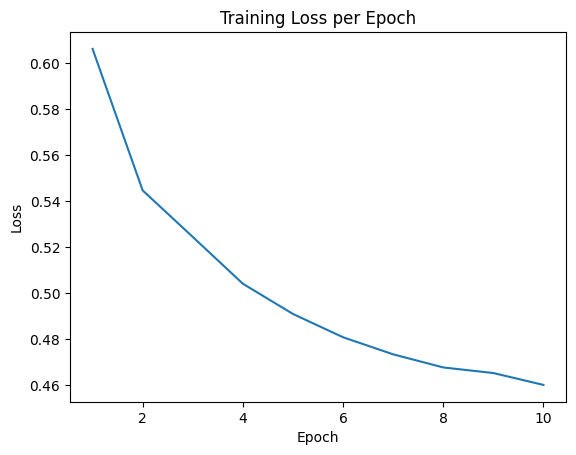

In [89]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.show()

### Skorovi za trening parove

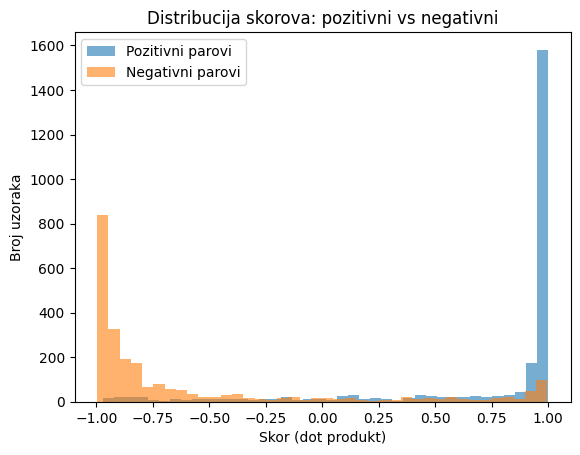

In [119]:
u_emb_train = user_tower.predict(
    [u_num, u_bin, u_fuel, u_seller, u_trans, u_owner],
    verbose=0,
)
i_emb_train = item_tower.predict(
    [i_num, i_bin, i_fuel, i_seller, i_trans, i_owner],
    verbose=0,
)

train_scores = np.sum(u_emb_train * i_emb_train, axis=1)

# podela po labeli
pos_scores = train_scores[y == 1]
neg_scores = train_scores[y == 0]

# graf
import matplotlib.pyplot as plt

plt.figure()
plt.hist(pos_scores, bins=40, alpha=0.6, label="Pozitivni parovi")
plt.hist(neg_scores, bins=40, alpha=0.6, label="Negativni parovi")
plt.xlabel("Skor (dot produkt)")
plt.ylabel("Broj uzoraka")
plt.legend()
plt.title("Distribucija skorova: pozitivni vs negativni")
plt.show()


Vidimo jasno razdvajanje skorova pozitivnih i negativnih parova.

In [113]:
def recommend_for_user(user_pref: dict, top_n=10):
    user_num = np.array([[user_pref[c] for c in NUM_COLS]], dtype="float32")
    user_bin = np.array([[user_pref[c] for c in BIN_COLS]], dtype="float32")

    user_fuel = np.array([user_pref["fuel"]], dtype="int32")
    user_seller = np.array([user_pref["seller_type"]], dtype="int32")
    user_trans = np.array([user_pref["transmission"]], dtype="int32")
    user_owner = np.array([user_pref["owner"]], dtype="int32")

    u_emb = user_tower.predict(
        [user_num, user_bin, user_fuel, user_seller, user_trans, user_owner],
        verbose=0,
    )

    scores = (u_emb @ item_embeddings.T).ravel()
    sorted_idx = np.argsort(scores)[::-1]

    seen_names = set()
    selected_idx = []
    selected_scores = []

    for idx in sorted_idx:
        name = df.iloc[idx]["name"]
        if name not in seen_names:
            seen_names.add(name)
            selected_idx.append(idx)
            selected_scores.append(float(scores[idx]))
        if len(selected_idx) == top_n:
            break

    out = df.iloc[selected_idx][
        ["name", "year", "selling_price", "km_driven", "fuel", "transmission", "owner"]
    ].copy()
    return out

### Test

In [114]:
SEGMENT_NAMES = {
    1: "Sport",
    2: "Budzet",
    3: "Porodica",
    4: "Dizel",
}

def make_user_pref(segment: int) -> dict:
    if segment == 1:  # Sport
        return {
            "year": 0.80,
            "selling_price": 0.85,
            "km_driven": 0.15,
            "mileage": 0.45,
            "engine": 0.70,
            "max_power": 0.95,
            "torque_nm": 0.85,
            "seats": 0.25,
            "fuel": petrol_code,
            "seller_type": get_code("seller_type", "Dealer"),
            "transmission": manual_code,
            "owner": first_owner_code,
            "body_suv": 0,
            "body_sedan": 0,
            "body_coupe": 1,
            "is_premium_brand": 0,
        }

    if segment == 2:  # Budzet
        return {
            "year": 0.45,
            "selling_price": 0.20,
            "km_driven": 0.65,
            "mileage": 0.85,
            "engine": 0.35,
            "max_power": 0.35,
            "torque_nm": 0.35,
            "seats": 0.55,
            "fuel": petrol_code,
            "seller_type": get_code("seller_type", "Individual"),
            "transmission": manual_code,
            "owner": first_owner_code,
            "body_suv": 0,
            "body_sedan": 1,
            "body_coupe": 0,
            "is_premium_brand": 0,
        }

    if segment == 3:  # Porodica
        return {
            "year": 0.80,
            "selling_price": 0.55,
            "km_driven": 0.25,
            "mileage": 0.65,
            "engine": 0.55,
            "max_power": 0.55,
            "torque_nm": 0.55,
            "seats": 0.85,
            "fuel": int(np.random.choice([petrol_code, diesel_code])),
            "seller_type": get_code("seller_type", "Dealer"),
            "transmission": auto_code,
            "owner": first_owner_code,
            "body_suv": 1,
            "body_sedan": 0,
            "body_coupe": 0,
            "is_premium_brand": 0,
        }

    if segment == 4:  # Dizel
        return {
            "year": 0.70,
            "selling_price": 0.45,
            "km_driven": 0.45,
            "mileage": 0.75,
            "engine": 0.60,
            "max_power": 0.50,
            "torque_nm": 0.80,
            "seats": 0.55,
            "fuel": diesel_code,
            "seller_type": get_code("seller_type", "Dealer"),
            "transmission": manual_code,
            "owner": first_owner_code,
            "body_suv": 0,
            "body_sedan": 1,
            "body_coupe": 0,
            "is_premium_brand": 0,
        }

    raise ValueError("segment must be 1..4")


In [115]:
print(f"\n{SEGMENT_NAMES[1]}")
display(recommend_for_user(make_user_pref(1), top_n=10))


Sport


,name,year,selling_price,km_driven,fuel,transmission,owner
1348,Ford Mustang Shelby GT500,0.862069,0.078179,0.013999,4,1,1
825,Chevrolet Corvette E-Ray,1.000000,0.131792,0.002666,4,1,1
384,Bentley Continental GT Speed,0.896552,0.171801,0.015999,4,1,1
11,Bentley Continental GT Mulliner,0.931034,0.195807,0.013999,4,1,1
411,Chevrolet Corvette ZR1,0.827586,0.115788,0.014666,4,1,1
1331,Bentley Continental GT V8,0.827586,0.131792,0.027999,4,1,3
824,Chevrolet Camaro LT1 Coupe,0.896552,0.038169,0.019333,4,2,1
1350,Chevrolet Corvette Stingray C7,0.724138,0.060575,0.031999,4,2,3
822,Ford Mustang Shelby GT350R,0.827586,0.073378,0.018666,4,2,3
1457,Nissan GT-R Nismo Special,0.862069,0.147795,0.013999,4,1,1


In [116]:
print(f"\n{SEGMENT_NAMES[2]}")
display(recommend_for_user(make_user_pref(2), top_n=10))


Budzet


,name,year,selling_price,km_driven,fuel,transmission,owner
1057,Hyundai Verna 1.4 CRDi,0.689655,0.003961,0.165333,2,2,1
1513,Hyundai Verna 1.6 SX,0.586207,0.003361,0.133333,2,2,3
769,Maruti Wagon R CNG LXI,0.620690,0.001920,0.053333,1,2,3
23,Honda City i DTEC VX,0.655172,0.006322,0.133333,2,2,1
1437,Hyundai Verna SX Diesel,0.620690,0.004161,0.053333,2,2,1
734,Maruti Swift VDI BSIV,0.413793,0.001320,0.075253,2,2,1
1595,Hyundai Verna 1.6 SX CRDi (O),0.551724,0.003361,0.085333,2,2,3
1052,Maruti Wagon R Duo Lxi,0.551724,0.002161,0.199999,3,2,1
192,Mahindra XUV500 W6 2WD,0.586207,0.003761,1.000000,2,2,1
497,Maruti Ciaz VDi Plus,0.655172,0.003441,0.096666,2,2,3


In [117]:
print(f"\n{SEGMENT_NAMES[3]}")
display(recommend_for_user(make_user_pref(3), top_n=10))


Porodica


,name,year,selling_price,km_driven,fuel,transmission,owner
454,Mahindra Scorpio VLX 2WD AIRBAG BSIV,0.655172,0.004161,0.199999,2,2,4
305,Ford Endeavour 3.2 Titanium AT 4X4,0.724138,0.018004,0.079999,2,1,3
1190,Toyota Fortuner 4x2 Manual,0.655172,0.010803,0.099999,2,2,1
1358,Toyota Innova Crysta 2.4 VX MT 8S BSIV,0.724138,0.013283,0.079999,2,2,1
825,Chevrolet Corvette E-Ray,1.000000,0.131792,0.002666,4,1,1
288,Toyota Fortuner 4x4 MT,0.689655,0.014868,0.079999,2,2,3
203,Toyota Fortuner 2.8 4WD MT BSIV,0.793103,0.025366,0.033333,2,2,1
216,Toyota Fortuner 2.8 4WD AT BSIV,0.793103,0.025366,0.039999,2,1,1
1259,Mahindra XUV500 W8 4WD,0.586207,0.003761,0.133333,2,2,2
1348,Ford Mustang Shelby GT500,0.862069,0.078179,0.013999,4,1,1


In [118]:
print(f"\n{SEGMENT_NAMES[4]}")
display(recommend_for_user(make_user_pref(4), top_n=10))


Dizel


,name,year,selling_price,km_driven,fuel,transmission,owner
1247,BMW 5 Series 520d Sport Line,0.482759,0.007562,0.053333,2,1,3
526,BMW 3 Series 320d Luxury Line,0.586207,0.010162,0.093333,2,1,3
522,BMW 3 Series 320d Luxury Plus,0.620690,0.010162,0.093333,2,1,3
1052,Maruti Wagon R Duo Lxi,0.551724,0.002161,0.199999,3,2,1
734,Maruti Swift VDI BSIV,0.413793,0.001320,0.075253,2,2,1
511,Hyundai Verna 1.6 SX CRDi (O),0.586207,0.002961,0.091999,2,2,1
1261,BMW 3 Series 320d Corporate Edition,0.586207,0.006962,0.103333,2,1,3
1599,Hyundai Verna 1.6 SX,0.586207,0.003361,0.085333,2,2,3
1236,Maruti Swift VDI,0.620690,0.002761,0.043333,2,2,1
1091,Maruti Wagon R LXI CNG,0.551724,0.001360,0.091333,1,2,1
